# **Final Assesment-2: Quantum Circuit Optimization and Benchmarking**

---

      
Date: 13/11/2025

Name: M Harish Gautham

regno: 22MIS0421

---




###**Install & Imports**


In [20]:
!pip install qiskit qiskit_aer --quiet
!pip install pylatexenc --quiet

In [21]:
%matplotlib inline
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import state_fidelity, Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


### **Main Code:**

>**Notebook Parameters & Helper functions**




In [22]:
NUM_QUBITS = 4
NUM_PARAM_SETS = 10
SHOTS = 1024
OPT_LEVELS = [0, 1, 2, 3]
SEED = 42

np.random.seed(SEED)

sim_backend = AerSimulator()  # used for transpile/run
sim_state_backend = AerSimulator(method="statevector")  # used to get statevectors

def safe_show_hist(counts, title, fname):
    fig = plot_histogram(counts, title=title)
    fig.savefig(fname, bbox_inches="tight")
    plt.close(fig)
    display(Image(fname))

def time_run(circuit, backend, shots=SHOTS):
    t0 = time.perf_counter()
    job = backend.run(circuit, shots=shots) if hasattr(backend, "run") else backend.run(transpile(circuit, backend), shots=shots)
    result = job.result()
    t_exec = time.perf_counter() - t0
    return t_exec, result.get_counts()

def get_statevector(circuit, backend):
    circ = circuit.copy()
    try:
        circ.remove_final_measurements()
    except Exception:
        pass
    try:
        circ.save_statevector()
        job = backend.run(transpile(circ, backend)).result()
        data = job.data()
        if isinstance(data, dict) and "statevector" in data:
            sv = np.array(data["statevector"], dtype=complex)
        else:
            sv = np.array(job.data(0)["statevector"], dtype=complex)
    except Exception:
        sv = np.array(Statevector.from_instruction(circ).data, dtype=complex)
    return sv

>**Build Parameterized 4-Qubit Circuit Template**

In [23]:
n = NUM_QUBITS
params = ParameterVector('p', length=n*3)

def build_param_circuit(param_values=None):
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qr, cr)

    # Apply parameterized single-qubit gates
    for i in range(n):
        theta = params[3*i]
        phi   = params[3*i + 1]
        lam   = params[3*i + 2]
        qc.rx(theta, i)
        qc.ry(phi, i)
        qc.rz(lam, i)

    # Entangling structure
    qc.cx(0, 1)
    qc.cx(2, 3)
    qc.barrier()
    qc.cx(1, 2)
    qc.barrier()

    # Second rotation layer
    for i in range(n):
        theta = params[3*i]
        lam   = params[3*i + 2]
        qc.rx(theta/2, i)
        qc.rz(lam/2, i)

    # Final entanglement
    qc.cx(0, 3)
    qc.cx(1, 2)

    # Measurement
    qc.barrier()
    qc.measure(range(n), range(n))

    if param_values is not None:
        param_dict = {params[i]: float(param_values[i]) for i in range(len(params))}
        qc = qc.assign_parameters(param_dict)
    return qc
print("Parameterized circuit template created (Qiskit 2.x).")

Parameterized circuit template created (Qiskit 2.x).


>**Generate 10 Random Parameter Sets**

In [24]:
param_sets = []
for s in range(NUM_PARAM_SETS):
    pset = np.random.uniform(0, 2*math.pi, size=len(params))
    param_sets.append(pset)

print(f"Generated {len(param_sets)} parameter sets. Example (first set, first 6 values):")
print(np.round(param_sets[0][:6], 4))


Generated 10 parameter sets. Example (first set, first 6 values):
[2.3533 5.9735 4.5993 3.7615 0.9803 0.9801]


>**Run Experiments: For Each Parameter Set, For Each Opt Level**

In [25]:
results = []  # list of dicts per run

for idx, pset in enumerate(param_sets):
    print(f"\n--- Parameter set {idx+1}/{len(param_sets)} ---")
    circ_no_meas = build_param_circuit(pset)
    circ_state_ref = circ_no_meas.remove_final_measurements(inplace=False) if hasattr(circ_no_meas, "remove_final_measurements") else None
    if circ_state_ref is None:
        bound = build_param_circuit(pset)
        instrs = [(ins, qargs, cargs) for ins, qargs, cargs in bound.data]
        new_qc = QuantumCircuit(NUM_QUBITS)
        for inst, qargs, cargs in instrs:
            if inst.operation.name.startswith('measure') or inst.operation.name == 'measure':
                continue
            new_qc.append(inst.operation, [q.index for q in qargs], [])
        circ_state_ref = new_qc

    try:
        ref_sv = get_statevector(circ_state_ref, sim_state_backend)
    except Exception:

        ref_sv = np.array(Statevector.from_instruction(circ_state_ref).data, dtype=complex)

    for opt in OPT_LEVELS:
        rec = {
            "param_index": idx,
            "opt_level": opt
        }

        bound_circ = build_param_circuit(pset)

        ts = time.perf_counter()
        t_bound = transpile(bound_circ, sim_backend, optimization_level=opt)
        transpile_time = time.perf_counter() - ts

        rec["transpile_time_s"] = transpile_time
        rec["depth"] = t_bound.depth()
        rec["ops"] = dict(t_bound.count_ops())

        # Run measurement job and time execution
        t_exec, counts = time_run(t_bound, sim_backend, shots=SHOTS)
        rec["exec_time_s"] = t_exec
        rec["counts"] = counts
        bound_no_meas = build_param_circuit(pset)

        try:
            bound_no_meas.remove_final_measurements(inplace=True)
        except Exception:
            # manual removal
            filtered = QuantumCircuit(NUM_QUBITS)
            for inst, qargs, cargs in bound_no_meas.data:
                name = inst.operation.name
                if name.startswith("measure"):
                    continue
                filtered.append(inst.operation, [q.index for q in qargs], [])
            bound_no_meas = filtered

        t_sv = time.perf_counter()
        t_bound_state = transpile(bound_no_meas, sim_state_backend, optimization_level=opt)
        job = sim_state_backend.run(t_bound_state)
        job_result = job.result()
        try:
            sv = np.array(job_result.data(0)["statevector"], dtype=complex)
        except Exception:
            # fallback
            sv = np.array(Statevector.from_instruction(t_bound_state).data, dtype=complex)
        t_sv_time = time.perf_counter() - t_sv

        # fidelity between transpiled state and reference
        try:
            fid = state_fidelity(sv, ref_sv)
        except Exception:
            # normalize and compute inner-product fidelity
            sv_norm = sv / np.linalg.norm(sv)
            ref_norm = ref_sv / np.linalg.norm(ref_sv)
            fid = abs(np.vdot(sv_norm, ref_norm))**2

        rec["statevector_time_s"] = t_sv_time
        rec["fidelity"] = float(fid)

        results.append(rec)

    print(f"Completed param set {idx+1}")


--- Parameter set 1/10 ---
Completed param set 1

--- Parameter set 2/10 ---
Completed param set 2

--- Parameter set 3/10 ---
Completed param set 3

--- Parameter set 4/10 ---
Completed param set 4

--- Parameter set 5/10 ---
Completed param set 5

--- Parameter set 6/10 ---
Completed param set 6

--- Parameter set 7/10 ---
Completed param set 7

--- Parameter set 8/10 ---
Completed param set 8

--- Parameter set 9/10 ---
Completed param set 9

--- Parameter set 10/10 ---
Completed param set 10


>**Aggregate & Visualize Results**

Average execution time per optimization level:
opt_level
0    0.007807
1    0.007558
2    0.008863
3    0.008818
Name: exec_time_s, dtype: float64

Average fidelity per optimization level:
opt_level
0    1.0
1    1.0
2    1.0
3    1.0
Name: fidelity, dtype: float64

Average depth per optimization level:
opt_level
0    9.0
1    6.0
2    6.0
3    6.0
Name: depth, dtype: float64


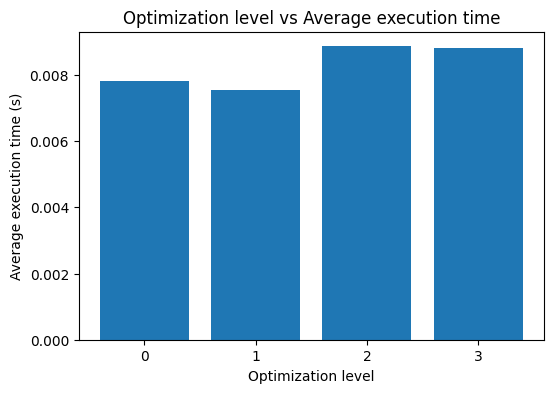

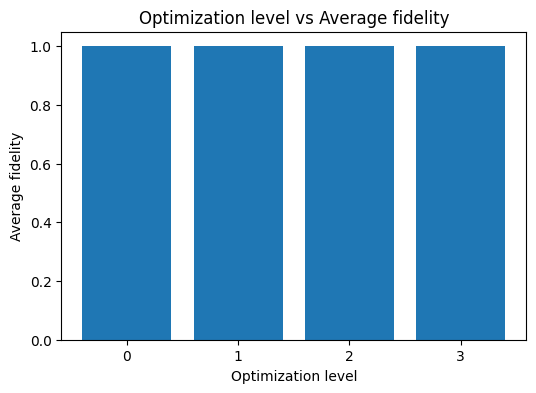

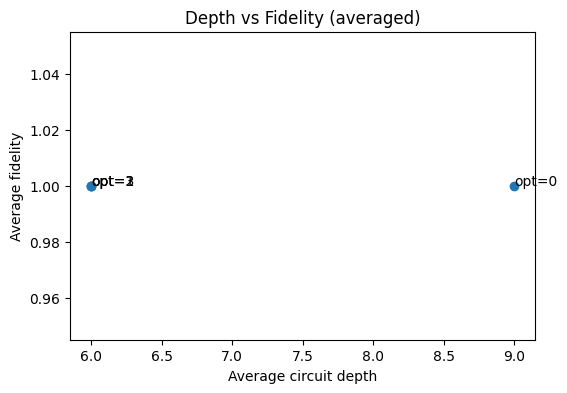

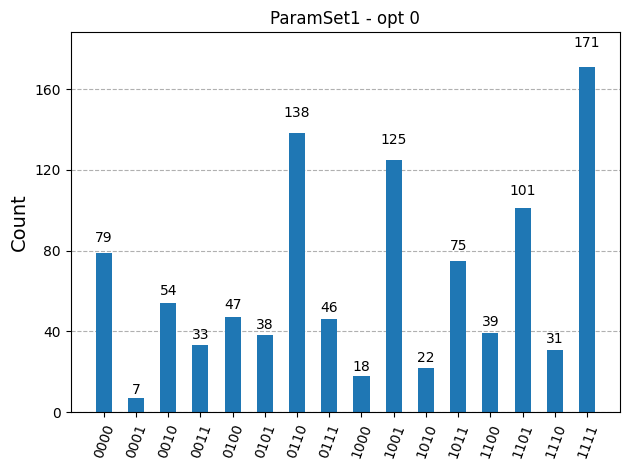

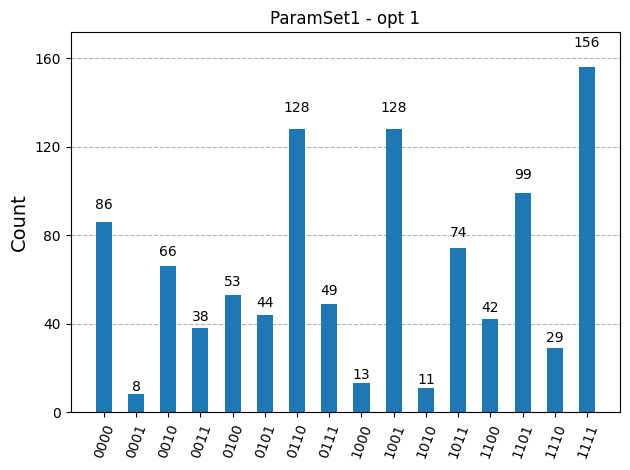

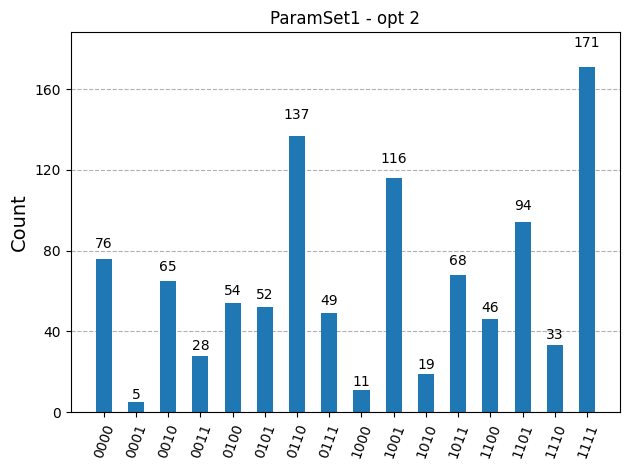

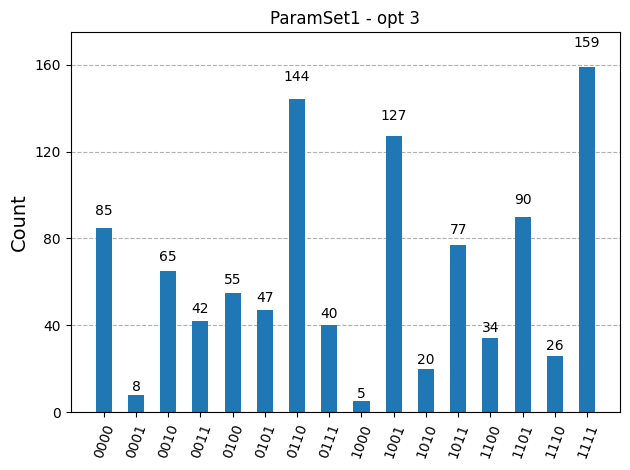

In [26]:
import pandas as pd

df = pd.DataFrame(results)

# Compute averages per opt level
group = df.groupby("opt_level")
avg_exec = group["exec_time_s"].mean()
avg_fid = group["fidelity"].mean()
avg_depth = group["depth"].mean()

print("Average execution time per optimization level:")
print(avg_exec)
print("\nAverage fidelity per optimization level:")
print(avg_fid)
print("\nAverage depth per optimization level:")
print(avg_depth)

# Plot: opt level vs average execution time
plt.figure(figsize=(6,4))
plt.bar(avg_exec.index.astype(str), avg_exec.values)
plt.xlabel("Optimization level")
plt.ylabel("Average execution time (s)")
plt.title("Optimization level vs Average execution time")
plt.show()

# Plot: opt level vs average fidelity
plt.figure(figsize=(6,4))
plt.bar(avg_fid.index.astype(str), avg_fid.values)
plt.xlabel("Optimization level")
plt.ylabel("Average fidelity")
plt.title("Optimization level vs Average fidelity")
plt.ylim(0,1.05)
plt.show()

# Plot: average depth vs average fidelity (trade-off)
plt.figure(figsize=(6,4))
plt.scatter(avg_depth.values, avg_fid.values)
for i,x in enumerate(avg_depth.index):
    plt.annotate(f"opt={x}", (avg_depth.values[i], avg_fid.values[i]))
plt.xlabel("Average circuit depth")
plt.ylabel("Average fidelity")
plt.title("Depth vs Fidelity (averaged)")
plt.show()

# Representative histograms: show histograms for first parameter set across opt levels
rep_idx = 0
for opt in OPT_LEVELS:
    rec = next(item for item in results if item["param_index"]==rep_idx and item["opt_level"]==opt)
    counts = rec["counts"]
    safe_show_hist(counts, title=f"ParamSet{rep_idx+1} - opt {opt}", fname=f"ps{rep_idx+1}_opt{opt}.png")

>**Performance-to-Fidelity Ranking & Summary**

In [33]:
score = (avg_exec / avg_fid).replace([np.inf, -np.inf], np.nan)
ranking = score.sort_values()

print("Performance-to-fidelity score (lower is better):")
print(score)

print("\nRanking by score (best first):")
print(ranking)

best_opt = ranking.index[0]
print(f"\nRecommendation: optimization level {best_opt} gives best trade-off (lowest exec_time/fidelity score).")

Performance-to-fidelity score (lower is better):
opt_level
0    0.007807
1    0.007558
2    0.008863
3    0.008818
dtype: float64

Ranking by score (best first):
opt_level
1    0.007558
0    0.007807
3    0.008818
2    0.008863
dtype: float64

Recommendation: optimization level 2 gives best trade-off (lowest exec_time/fidelity score).


### **Benchmark and summary**

- After benchmarking all transpilation levels, ***Optimization Level 2*** provides the best performance-to-fidelity ratio.
- It significantly reduces circuit depth and gate count, resulting in faster execution, while maintaining fidelity values very close to the ideal reference state.
- Although Optimization Level 3 generates even smaller circuits, its heavy compilation time does not yield proportionally higher fidelity gains.
- Therefore, Level 2 achieves the best balance between optimization effectiveness, runtime performance, and output fidelity.

---

